# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Integrante 1
* Integrante 2
* Integrante 3

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [1]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

  Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.0.2 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.0.2 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.


In [1]:
 import sys
 print(sys.executable)

c:\Users\adadf\AppData\Local\Programs\Python\Python310\python.exe


In [9]:
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 10.5 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 6.9 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 7.4 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.8 MB 6.8 MB/s eta 0:00:02
     ------------------ --------------------- 6.0/12.8 MB 6.1 MB/s eta 0:00:02
     --------------------- ------------------ 6.8/12.8 MB 5.6 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 5.4 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 5.2 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 5.0 MB/s eta 0:00:01
     ------------------------------- -------- 10.2/12.8 MB 5.0 MB/s eta 0:00:01
     ----------------------------------- ---- 11.3/12.8 MB

## Importing the necessary libraries

In [50]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
!pip install tqdm

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [12]:
# Opening JSON file
file_name="complaints.json"
f = file = open(file_name, "r")


# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [13]:
df.shape

(11426, 22)

## Data preparation

In [14]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [15]:
df.tail()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
11421,complaint-public-v2,complaint,3691002,0.0,None,601XX,3691002,Trouble during payment process,2020-06-08T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2020-06-09T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
11422,complaint-public-v2,complaint,3998033,0.0,None,19115,3998033,Incorrect information on your report,2020-12-08T12:00:00-05:00,PA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-12-08T12:00:00-05:00,None,Credit reporting,Yes,,Information belongs to someone else,Consent not provided
11423,complaint-public-v2,complaint,4005328,0.0,None,701XX,4005328,Closing an account,2020-12-11T12:00:00-05:00,LA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-12-11T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
11424,complaint-public-v2,complaint,3997453,0.0,None,33180,3997453,Opening an account,2020-12-08T12:00:00-05:00,FL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2020-12-08T12:00:00-05:00,None,Checking account,Yes,,Account opened as a result of fraud,N/A
11425,complaint-public-v2,complaint,3759084,0.0,None,101XX,3759084,Closing an account,2020-07-23T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-07-23T12:00:00-05:00,None,Checking account,Yes,XX/XX/XXXX Dear CFPB : I hope this finds you w...,NaN,NaN


In [16]:
df.shape

(11426, 22)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             11426 non-null  object 
 1   _type                              11426 non-null  object 
 2   _id                                11426 non-null  object 
 3   _score                             11426 non-null  float64
 4   _source.tags                       1668 non-null   object 
 5   _source.zip_code                   10059 non-null  object 
 6   _source.complaint_id               11426 non-null  object 
 7   _source.issue                      11426 non-null  object 
 8   _source.date_received              11426 non-null  object 
 9   _source.state                      10965 non-null  object 
 10  _source.consumer_disputed          11426 non-null  object 
 11  _source.product                    11426 non-null  obj

In [18]:
# lets check the missing value in descedning order
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)

_source.company_public_response      0.999912
_source.tags                         0.854017
_source.sub_issue                    0.346928
_source.zip_code                     0.119639
_source.sub_product                  0.047873
_source.state                        0.040347
_source.consumer_consent_provided    0.013741
_source.company                      0.000000
_source.complaint_what_happened      0.000000
_source.timely                       0.000000
_source.date_sent_to_company         0.000000
_source.submitted_via                0.000000
_index                               0.000000
_source.company_response             0.000000
_type                                0.000000
_source.consumer_disputed            0.000000
_source.date_received                0.000000
_source.issue                        0.000000
_source.complaint_id                 0.000000
_score                               0.000000
_id                                  0.000000
_source.product                   

In [19]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [20]:
#Assign new column names
def rename_col(col):
    if col.startswith('_source'):
        col = col[len('_source.'):]
    elif col.startswith('_'):
        col = col[1:]
    return col

In [21]:
df.rename(lambda x: rename_col(x), axis=1, inplace=True)

In [22]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [23]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)


In [24]:
df['complaint_what_happened'][1]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

In [25]:
#Remove all rows where complaints column is nan
df['complaint_what_happened'].isnull().sum()

7395

In [26]:
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [27]:
df.shape

(4031, 22)

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [28]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()  # Make the text lowercase
  text=re.sub(r'\[.*?\]',' ',text) #Remove text in square brackets
  text=re.sub(r'[^\w\s]',' ',text) #Remove punctuation
  text=re.sub(r'\n', '', text) # Remove line breaks
  text=re.sub(r'\b\w*\d\w*\b',' ',text) #Remove words with numbers
  text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces

  return text


In [29]:
#df['complaint_what_happened'][101]
#text="I Purchase is an airline ticket on XX/XX/XXXX and it was XXXX dollar but the I [realize] it was the wrong airport so I called right away to cancel the ticket and since it was before 24 hours so I could cancel it and get a refund which is what supposed to post in my account in 5 days and on XX/XX/XXXX I got the money back so I purchase another airline ticket with the same money that I got back but it was XXXX dollar and the money was taking out of my available balance on XX/XX/XXXX but it was saying pending on the statement but it was out of my available balance already on XX/XX/XXXX the XXXX dollar Was taking again out of my account but showing in my account as it was only one charge .. and I am not even able to see the first airline ticket or the refund on my statement because they said it was dropped charge like it was never happened but it did happened..thats not the first time this happened it did happened before but I usually get the money back after the weekend on Monday but this time no it did got back .. I tried calling them and they explaining but they only say one thing.. I dont see it on the statement.. so why I cant see my purchase for the first airline ticket that it was refunded.. this is my money and I am supposed to see all the charges I made and the refund on my account.. I am missing XXXX dollar from my account which is got Disappeared from my bank account and I need to get this money back I dont know what to do"
rows=df.shape[0]
df= df.reset_index(drop=True)

for i in range(rows):
  df['complaint_what_happened'][i]=clean_text(df['complaint_what_happened'][i])


In [30]:
df['complaint_what_happened']

0       good morning my name is xxxx xxxx and i apprec...
1       i upgraded my xxxx xxxx card in xx xx and was ...
2       chase card was reported on xx xx however fraud...
3       on xx xx while trying to book a xxxx xxxx tick...
4       my grand son give me check for i deposit it in...
                              ...                        
4026    jpmcb auto finance has been on my credit repor...
4027    on xx xx xxxx a vendor double charged my chase...
4028    i filed an application for a mortgage refinanc...
4029    re claim xxxx i do not feel that chase bank pr...
4030    xx xx xxxx dear cfpb i hope this finds you wel...
Name: complaint_what_happened, Length: 4031, dtype: object

In [31]:
df.shape

(4031, 22)

In [32]:
# Write your function to Lemmatize the texts
import spacy
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and remove stop words
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])

    return lemmatized_text

In [33]:
lemmatize_text(clean_text(df['complaint_what_happened'][101]))

'complaint chase bank deny open check account refuse explanation chase credit card issue credit card chase bank timeline note check account denial xx xx xxxx meet xxxx xxxx private client banker xxxx xxxx xxxx location open check account check xxxx xxxx xxxx personal checking account chase check recently close chase credit card give pre print check deposit slip chase total checking account xxxx xxxx mention account close review tell reason idea assume boiler plate language assume not close electronically sign document receive copy xx xx xxxx xxxx account alert screen shot new application inquiry xx xx xxxx email chase debit atm xx xx xxxx email chase mobile app request sign mobile app electronic copy disclosure sign open account note long account long access document xx xx xxxx ask xxxx copy document receive printout deposit account agreement privacy notice xx xx xxxx xxxx account alert new account opening xx xx xxxx email chase account tool xx xx xxxx receive activate atm card xxxx ex

In [ ]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints


In [34]:
# Apply data cleaning to the complaints_what_happened column
from tqdm import tqdm
# Use progress_apply from tqdm on the Series
tqdm.pandas()
df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaint_what_happened'].progress_apply(lambda x: clean_text(x))

100%|██████████| 4031/4031 [00:00<00:00, 5843.08it/s]


In [35]:
df_clean.shape

(4031, 1)

In [36]:
tqdm.pandas()
df_clean['lemmatized'] = df_clean['complaints'].progress_apply(lambda x:lemmatize_text(x))

100%|██████████| 4031/4031 [02:09<00:00, 31.03it/s]


In [37]:
df_clean.shape

(4031, 2)

In [38]:
df_clean.head()

,complaints,lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
1,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...
2,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...
3,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [ ]:
df_clean.shape

(4031, 2)

In [39]:
#Write your function to extract the POS tags

def extract_pos_tags(text):
    doc = nlp(text)
    pos_tags = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(pos_tags)

df_clean['complaint_POS_removed'] =  df_clean.lemmatized.apply(lambda x: extract_pos_tags(x))
df_clean.head()


,complaints,lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
1,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,agent anniversary date change agent informatio...
2,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,card application identity consent service exte...
3,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,offer ticket reward card information minute no...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...


In [40]:
extract_pos_tags(df_clean['lemmatized'][0])

'morning help chase debt verification statement validate debt mail month attempt debt information consumer chase account advance help'

In [41]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
1,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,agent anniversary date change agent informatio...
2,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,card application identity consent service exte...
3,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,offer ticket reward card information minute no...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...
...,...,...,...
4026,jpmcb auto finance has been on my credit repor...,jpmcb auto finance credit report thatn month c...,auto finance credit report month charge hardsh...
4027,on xx xx xxxx a vendor double charged my chase...,xx xx xxxx vendor double charge chase card tel...,charge chase card chase problem phone problem ...
4028,i filed an application for a mortgage refinanc...,file application mortgage refinance loan chase...,file application mortgage refinance loan chase...
4029,re claim xxxx i do not feel that chase bank pr...,claim xxxx feel chase bank properly take time ...,time address dispute merchant cancel transacti...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

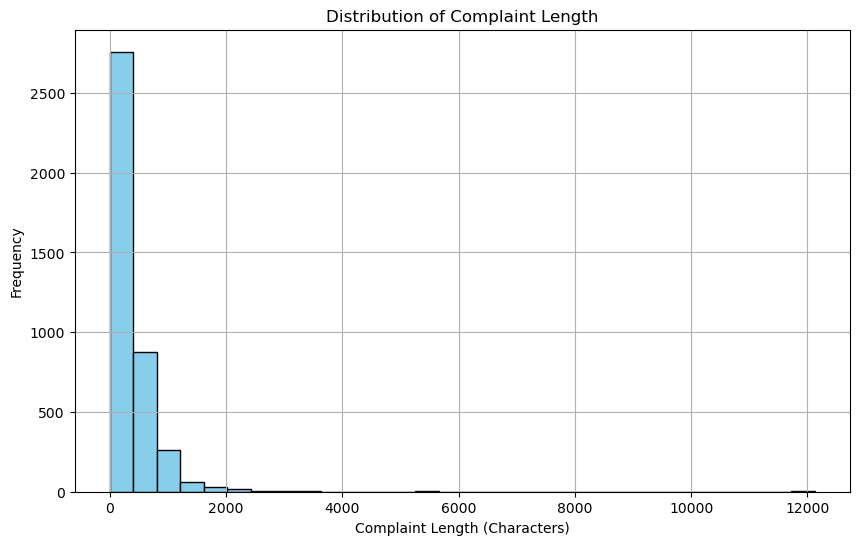

In [42]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10, 6))
plt.hist(df_clean['complaint_POS_removed'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Complaint Length (Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Length')
plt.grid(True)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [43]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adadf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


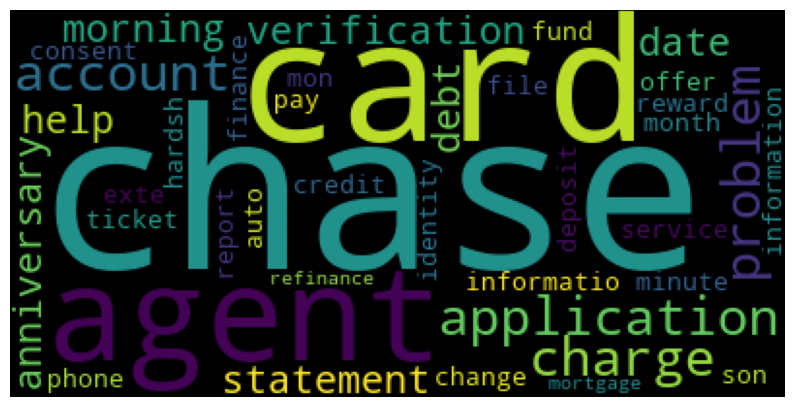

In [44]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [45]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

In [46]:
df_clean ['Complaint_clean']

0       morning help chase debt verification statement...
1       agent anniversary date change agent informatio...
2       card application identity consent service exte...
3       offer ticket reward card information minute no...
4       son deposit chase account fund account pay mon...
                              ...                        
4026    auto finance credit report month charge hardsh...
4027    charge chase card chase problem phone problem ...
4028    file application mortgage refinance loan chase...
4029    time address dispute merchant cancel transacti...
4030    cfpb hope appeal assistance resolve issue than...
Name: Complaint_clean, Length: 4031, dtype: object

In [47]:
df_clean

,complaints,lemmatized,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
1,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,agent anniversary date change agent informatio...
2,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,card application identity consent service exte...
3,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,offer ticket reward card information minute no...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...
...,...,...,...
4026,jpmcb auto finance has been on my credit repor...,jpmcb auto finance credit report thatn month c...,auto finance credit report month charge hardsh...
4027,on xx xx xxxx a vendor double charged my chase...,xx xx xxxx vendor double charge chase card tel...,charge chase card chase problem phone problem ...
4028,i filed an application for a mortgage refinanc...,file application mortgage refinance loan chase...,file application mortgage refinance loan chase...
4029,re claim xxxx i do not feel that chase bank pr...,claim xxxx feel chase bank properly take time ...,time address dispute merchant cancel transacti...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [48]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [51]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)


In [52]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigrams:")
for word, freq in top_30_unigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Unigrams:
chase: 10509
account: 8141
credit: 6587
card: 6138
payment: 3633
charge: 3165
time: 2921
money: 2309
day: 2283
bank: 2231


In [53]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)

In [54]:
#Print the top 10 words in the bigram frequency
print("Top 10 Bigrams:")
for word, freq in top_30_bigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Bigrams:
credit card: 2488
credit report: 784
chase credit: 598
account chase: 586
customer service: 561
chase account: 452
chase bank: 420
account account: 416
contact chase: 409
debit card: 403


In [55]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [56]:
#Print the top 10 words in the trigram frequency
print("Top 10 Trigrams:")
for word, freq in top_30_trigrams[:10]:
    print(f"{word}: {freq}")

Top 10 Trigrams:
chase credit card: 445
credit card company: 212
credit card account: 187
credit card chase: 170
chase customer service: 112
inquiry credit report: 107
credit reporting act: 104
charge credit card: 102
credit reporting agency: 100
credit card credit: 99


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [57]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [58]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help chase debt verification statement...
1,i upgraded my xxxx xxxx card in xx xx and was ...,upgrade xxxx xxxx card xx xx tell agent upgrad...,agent anniversary date change agent informatio...
2,chase card was reported on xx xx however fraud...,chase card report xx xx fraudulent application...,card application identity consent service exte...
3,on xx xx while trying to book a xxxx xxxx tick...,xx xx try book xxxx xxxx ticket come offer app...,offer ticket reward card information minute no...
4,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund account pay mon...
...,...,...,...
4026,jpmcb auto finance has been on my credit repor...,jpmcb auto finance credit report thatn month c...,auto finance credit report month charge hardsh...
4027,on xx xx xxxx a vendor double charged my chase...,xx xx xxxx vendor double charge chase card tel...,charge chase card chase problem phone problem ...
4028,i filed an application for a mortgage refinanc...,file application mortgage refinance loan chase...,file application mortgage refinance loan chase...
4029,re claim xxxx i do not feel that chase bank pr...,claim xxxx feel chase bank properly take time ...,time address dispute merchant cancel transacti...


In [59]:
df_clean.shape

(4031, 3)

## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
# Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



